# Why Does the World Need Regularization?
 

Deep learning models have a high capacity to fit complex patterns of data, especially when the model is too complex. This means that while the model performs perfectly on the training dataset, it doesn't perform as well on the test dataset. To reduce overfitting, we can take measures both on the model and the dataset.

Increasing the size of the dataset can help, but it's often costly, time-consuming, and sometimes not possible. Assuming we have a high-quality dataset, we can optimize the model using techniques like early stopping, dropout, and L2 regularization.

---

### L2 Regularization

L2 regularization, also known as Ridge regularization, works by adding a penalty term to the loss function, which helps reduce the weights of the model during updates. This is also known as weight decay. 

***The penalty term for L2 regularization is given by the formula:***

$$ L_{reg} = L + \frac{\lambda}{2} \sum_{i=1}^n w_i^2 $$

where \( L \) is the original loss function (e.g., mean squared error for regression), \( \lambda \) is the regularization parameter, and \( w_i \) represents the model weights. This formula helps keep the weight values close to zero but not exactly zero, preventing the model from becoming too complex.

---

#### Internal Workings

1. **Gradient Descent Adjustment**:
   - During training, gradient descent updates the weights to minimize the loss function.
   - With L2 regularization, the weight update rule becomes:
     $$ w_i = w_i - \eta \left( \frac{\partial L}{\partial w_i} + \lambda w_i \right) $$
   - Here, \( \eta \) is the learning rate.
   - The term \( \lambda w_i \) effectively shrinks the weights during each update, preventing them from growing too large.
   -  The squared term in the L2 regularization formula is to improve computational efficiency by avoiding the need    for square root calculations during backpropagation. This simplifies the derivative computation, making the training process faster and more efficient.

2. **Impact on Weight Magnitudes**:
   - The addition of \( \lambda w_i \) term ensures that the weights are not only driven by the gradient of the loss but also by their own magnitude.
   - This keeps the weights small and avoids overfitting by penalizing large weights more heavily.
---
#### Usefulness in bfloat16 for LLMs and CLIP etc

In large language models (LLMs) and CLIP model training, the use of bfloat16 (Brain Floating Point) is common due to its benefits in reducing memory usage and increasing computational efficiency. bfloat16 has a wider dynamic range compared to FP16, which makes it suitable for training large models.

1. **Numerical Stability**:
   - L2 regularization contributes to numerical stability during training by keeping the weights small. This is especially important in bfloat16, where the precision is lower than FP32.
   - Smaller weights reduce the risk of overflow or underflow during arithmetic operations, which can be a concern in lower precision formats like bfloat16.

2. **Gradient Scaling**:
   - In mixed precision training (using both FP32 and bfloat16), gradients can be scaled to maintain precision. L2 regularization helps ensure that the gradients do not become excessively large, which could otherwise lead to instability.
   - By keeping the weights and their updates within a manageable range, L2 regularization aids in maintaining the effectiveness of gradient scaling techniques.

---
#### In Short :

- Regularization is a common method for dealing with overfitting. It adds a penalty term to the loss function on the training set to reduce the complexity of the learned model.

- One particular choice for keeping the model simple is weight decay using an  penalty. This leads to weight decay in the update steps of the learning algorithm.

- The weight decay functionality is provided in optimizers from deep learning frameworks.

- Different sets of parameters can have different update behaviors within the same training loop.

--- 

### Why Don't We Use L1 Regularization?

While L2 regularization is widely used, L1 regularization is less common. L1 regularization adds a penalty term to the loss function without taking square of w (also make less computation efficient):

$$ L_{reg} = L + \lambda \sum_{i=1}^n |w_i| $$

***Some cons of L1 :***

1. **Sparsity**:
   - L1 regularization tends to drive many weights to exactly zero, resulting in sparse models. This can be useful for feature selection but is not always useful for all types of models, especially those where retaining all features is important for performance. Lots of information will be lost. (It might act like dropout with large prob)

2. **Optimization**:
   - The absolute value function is not differentiable at zero, which can make the optimization process more difficult. Gradient-based optimization algorithms may struggle with the non-smooth nature of the L1 penalty term, potentially leading to slower convergence.

3. **Less Effective for Overfitting**:
   - While L1 regularization can help with overfitting by encouraging sparsity, it is generally less effective than L2 regularization for large, complex models. L2 regularization provides a smoother penalty and better handles the overall complexity of the model.


# Code 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles, make_moons
from sklearn.preprocessing import StandardScaler

# Generate datasets
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
X = StandardScaler().fit_transform(X)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training function
def train(model, X, y, optimizer, criterion, epochs=10000, l2_lambda=0):
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        
        # Add L2 regularization
        if l2_lambda > 0:
            l2_reg = torch.tensor(0.)
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            loss += l2_lambda * l2_reg
        
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Train without L2
model_without_l2 = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_without_l2.parameters(), lr=0.01)
train(model_without_l2, X_tensor, y_tensor, optimizer, criterion)

Epoch 0, Loss: 0.7187150120735168
Epoch 100, Loss: 0.00030242474167607725
Epoch 200, Loss: 0.00010672098869690672
Epoch 300, Loss: 5.267096639727242e-05
Epoch 400, Loss: 3.1766045140102506e-05
Epoch 500, Loss: 2.1514935724553652e-05
Epoch 600, Loss: 1.1488788004498929e-05
Epoch 700, Loss: 8.106760105874855e-06
Epoch 800, Loss: 6.229605332919164e-06
Epoch 900, Loss: 4.984549377695657e-06
Epoch 1000, Loss: 4.1061180127144326e-06
Epoch 1100, Loss: 3.461304459051462e-06
Epoch 1200, Loss: 2.303060455233208e-06
Epoch 1300, Loss: 1.5817205394341727e-06
Epoch 1400, Loss: 1.2388138657115633e-06
Epoch 1500, Loss: 1.007345872494625e-06
Epoch 1600, Loss: 8.405965559177275e-07
Epoch 1700, Loss: 7.132979931157024e-07
Epoch 1800, Loss: 6.137702257547062e-07
Epoch 1900, Loss: 5.329550845090125e-07
Epoch 2000, Loss: 4.6691963007106096e-07
Epoch 2100, Loss: 4.1280350160377566e-07
Epoch 2200, Loss: 3.6595795904759143e-07
Epoch 2300, Loss: 3.2650254411237256e-07
Epoch 2400, Loss: 2.9241090260256897e-07
Ep

In [9]:
# Train with L2
model_with_l2 = Net()
optimizer = optim.Adam(model_with_l2.parameters(), lr=0.01)
train(model_with_l2, X_tensor, y_tensor, optimizer, criterion, l2_lambda=0.01)

Epoch 0, Loss: 0.8229808807373047
Epoch 100, Loss: 0.13738703727722168
Epoch 200, Loss: 0.12527190148830414
Epoch 300, Loss: 0.12484987825155258
Epoch 400, Loss: 0.12479835003614426
Epoch 500, Loss: 0.12481343746185303
Epoch 600, Loss: 0.12480704486370087
Epoch 700, Loss: 0.12479271739721298
Epoch 800, Loss: 0.12483431398868561
Epoch 900, Loss: 0.1247808113694191
Epoch 1000, Loss: 0.12488837540149689
Epoch 1100, Loss: 0.12484446167945862
Epoch 1200, Loss: 0.12480171024799347
Epoch 1300, Loss: 0.12476843595504761
Epoch 1400, Loss: 0.12475429475307465
Epoch 1500, Loss: 0.12477730959653854
Epoch 1600, Loss: 0.12482339143753052
Epoch 1700, Loss: 0.12479609251022339
Epoch 1800, Loss: 0.12483496963977814
Epoch 1900, Loss: 0.12478764355182648
Epoch 2000, Loss: 0.1248621791601181
Epoch 2100, Loss: 0.12477874755859375
Epoch 2200, Loss: 0.1247585266828537
Epoch 2300, Loss: 0.12490613013505936
Epoch 2400, Loss: 0.12478437274694443
Epoch 2500, Loss: 0.12482679635286331
Epoch 2600, Loss: 0.12476877

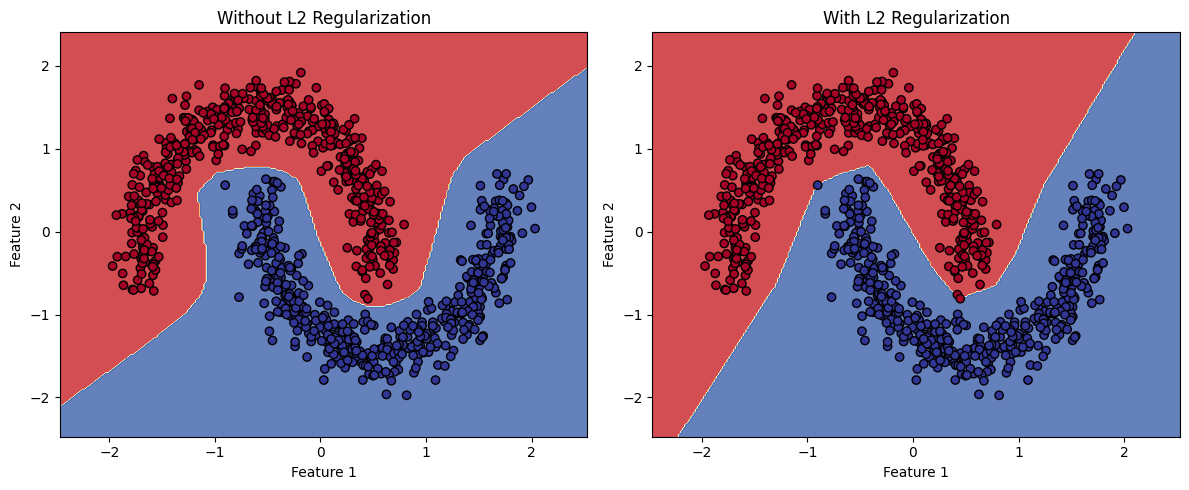

In [10]:
# Plotting function
def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).detach().numpy()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

# Plot decision boundaries
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_decision_boundary(X, y, model_without_l2, 'Without L2 Regularization')
plt.subplot(122)
plot_decision_boundary(X, y, model_with_l2, 'With L2 Regularization')
plt.tight_layout()
plt.show()

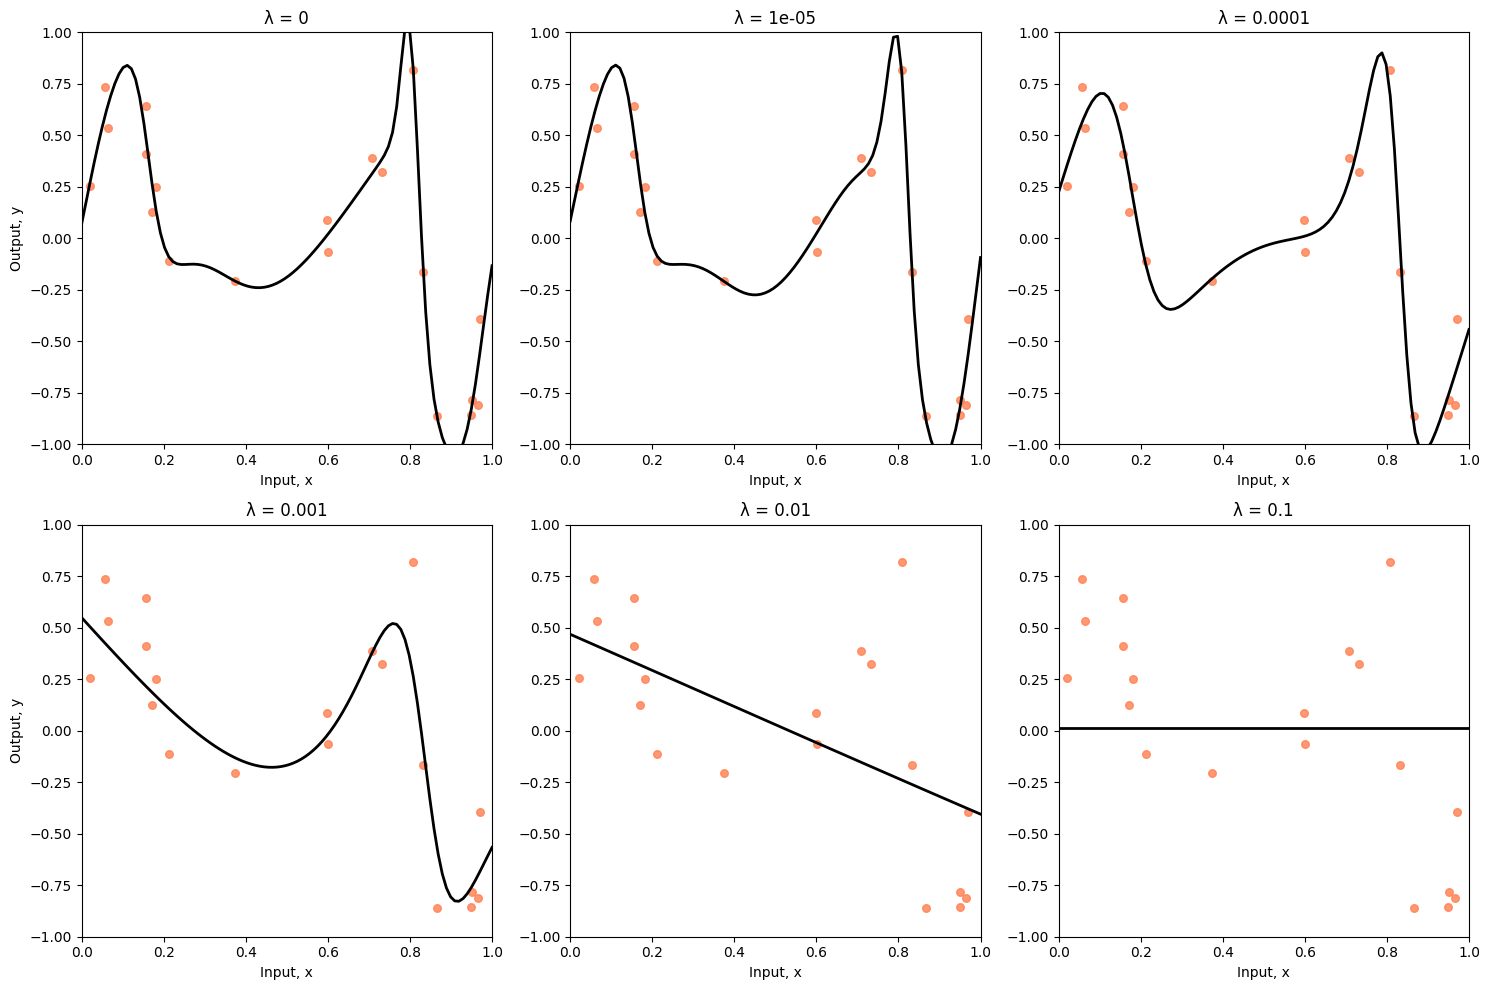

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Generate synthetic data
np.random.seed(42)
# Generate most of the points close together
x_close = np.random.uniform(0, 1, 15)
y_close = 0.5 * np.sin(4 * np.pi * x_close) + 0.5 * np.sin(6 * np.pi * x_close) + np.random.normal(0, 0.1, 15)

# Generate a few points further away
x_far = np.random.uniform(0, 1, 5)
y_far = 0.5 * np.sin(4 * np.pi * x_far) + 0.5 * np.sin(6 * np.pi * x_far) + np.random.normal(0, 0.5, 5)

# Combine the close and far points
x = np.concatenate([x_close, x_far])
y = np.concatenate([y_close, y_far])

# Convert to PyTorch tensors
x_tensor = torch.FloatTensor(x).view(-1, 1)
y_tensor = torch.FloatTensor(y).view(-1, 1)

# Neural Network definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Training function
def train(model, x, y, optimizer, criterion, epochs=1000, l2_lambda=0):
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        
        if l2_lambda > 0:
            l2_reg = sum(param.pow(2.0).sum() for param in model.parameters())
            loss += l2_lambda * l2_reg
        
        loss.backward()
        optimizer.step()

# Function to plot results
def plot_results(ax, x, y, model, lambda_val):
    x_cont = torch.linspace(0, 1, 100).view(-1, 1)
    y_pred = model(x_cont).detach().numpy()
    
    ax.scatter(x, y, color='coral', alpha=0.8, s=30)
    ax.plot(x_cont, y_pred, color='black', linewidth=2)
    ax.set_ylim(-1, 1)
    ax.set_xlim(0, 1)
    ax.set_title(f'λ = {lambda_val}')
    ax.set_xlabel('Input, x')
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel('Output, y')

# Lambda values to test
lambda_values = [0, 1e-5, 0.0001, 0.001, 0.01, 0.1]

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

for i, l2_lambda in enumerate(lambda_values):
    model = Net()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    train(model, x_tensor, y_tensor, optimizer, criterion, l2_lambda=l2_lambda)
    plot_results(axs[i], x, y, model, l2_lambda)

plt.tight_layout()
plt.show()
